# Signal Conversion Lab1 - Sar ADC

## General Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import os
from sympy import *
from numba.typed import List
from numba import njit, prange
from multiprocessing import Pool, cpu_count,set_start_method
from scipy.interpolate import interp1d

set_start_method('fork',force=True)

Blue    = (       0, 101/255, 189/255 )
Green   = (  52/255, 129/255,  65/255 )
Orange  = ( 241/255,  89/255,  41/255 )

#import datetime

TYPE = np.float64

def num2bin(n,n_bits):
    
    tmp = [ int(i) for i in bin(n)[2:] ]
    if len(tmp) < n_bits:
        code = np.append( [ int(0) for _ in range( int(n_bits) - len(tmp)  ) ],tmp  )
    else:
        code = np.asarray(tmp,dtype=int)
    
    return np.flip(code)
    


## DAC

$$V_x^{\phi_{n+1}} = V_x^{\phi_n}+V_{r}\frac{ C_{B} {\Delta}C_{Li} + C_{B} {\Delta}C_{Mi} + S_{LC} {\Delta}C_{Mi}}{C_{B}\left( S_{LC} + S_{MC}\right) + S_{LC} S_{MC}}$$


$~$
Where:

$\displaystyle S_{LC} = C_{0'} + \sum_{i=0}^{\text{bits LSB}}C_i$

$\displaystyle S_{MC} = C_{M0} + \sum_{i=0}^{\text{bits MSB}}(C_{ai}+C_{bi})$

$\displaystyle \Delta C_{Li} = \sum_{i}^{\text{bits LSB}}\left[ (C_i\cdot b_i)^{\phi_{n+1}} - (C_i\cdot b_i)^{\phi_{n}}\right]$ 

$\displaystyle\Delta C_{Mi} = \sum_{i}^{\text{bits MSB}}\left[ (C_i\cdot b_i)^{\phi_{n+1}} - (C_i\cdot b_i)^{\phi_{n}}\right]$ 

In [2]:
@njit(nopython=True,fastmath=True)
def dac_bit_weight(Vr,C_ai, C_bi,C_M0, C_Li,C_B,C_B0l,n_bits=-1):

    C_abi = C_ai + C_bi
    S_LC  = C_Li.sum() + C_B0l 
    S_MC  = C_abi.sum() + C_M0

    # First calculate constant values
    slope = Vr/( C_B*( S_MC + S_LC ) + S_LC*S_MC )

    if n_bits == -1:
        n_bits = C_ai.size + C_Li.size + 1
    
    tf_Li = np.column_stack((
        np.zeros_like(C_Li),
        slope * C_B * C_Li  
    ))

    tf_M0 = np.array([[
        0, 
        slope * (S_LC + C_B) * C_M0
    ]], dtype=TYPE)


    factor = slope * (S_LC + C_B)
    tf_ab  = np.column_stack((
        -factor * C_bi,
         factor * C_ai
    ))
    
    tf = np.vstack((tf_Li, tf_M0, tf_ab))
    
    return tf


def get_Vlsb_real( dac_tf ):
    
    dac_len = len(dac_tf) - 1
    return ( dac_tf[ dac_len  ] - dac_tf[0] ) / dac_len 

def get_INL(dac_tf, Vlsb_real):

    dac_len = len(dac_tf)
    return (dac_tf - np.arange(dac_len) * Vlsb_real - dac_tf[0]) / Vlsb_real

def get_DNL(dac_tf, Vlsb_real):

    return ((dac_tf[1:] - dac_tf[:-1]) / Vlsb_real) - 1
   

/usr/lib/python3.13/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Dac Test

[[ 0.          0.00048497]
 [ 0.          0.00096993]
 [ 0.          0.00193986]
 [ 0.          0.00387973]
 [ 0.          0.00775946]
 [-0.00775946  0.00775946]
 [-0.01551891  0.01551891]
 [-0.03103783  0.03103783]
 [-0.06207565  0.06207565]
 [-0.12415131  0.12415131]
 [-0.24830262  0.24830262]]
0.0009699321047526673


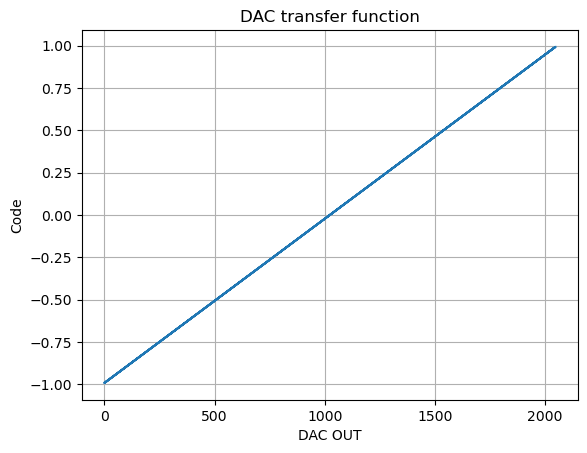

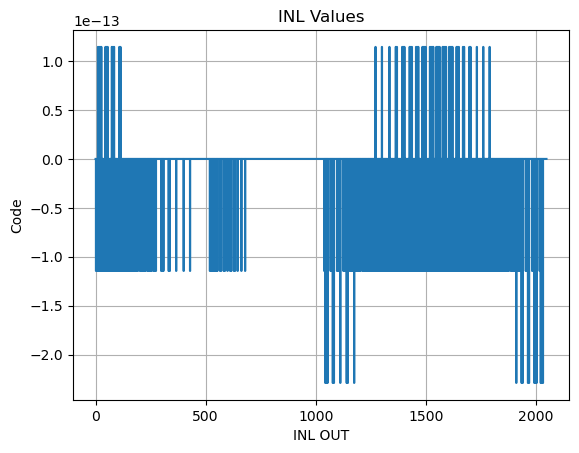

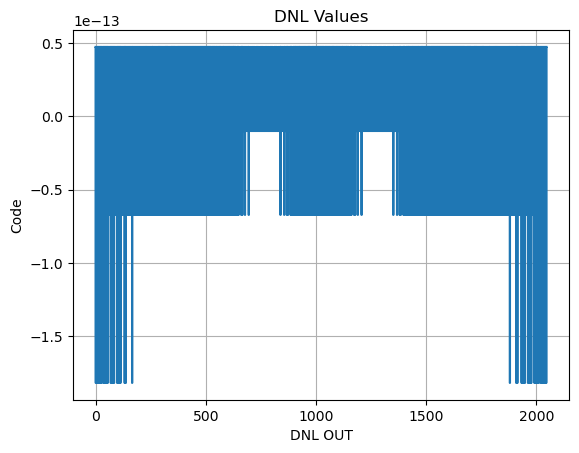

In [3]:
#Ideal values
n_bits  = 11
C_ai    = np.asarray([ 1, 2, 4, 8, 16,32])
C_bi    = np.asarray([ 1, 2, 4, 8, 16,32])
C_Li    = np.asarray([ 1, 2, 4, 8 ])
C_M0    = 1
C_B     = 2#(2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )#2
C_B0l   = ( (2**(len(C_Li))) - 1 )
vr      = 1
Voffset = 0 

weights = dac_bit_weight(
            vr,
            C_ai,
            C_bi,
            C_M0, 
            C_Li,
            C_B,
            C_B0l,
            n_bits=n_bits
) 
print(weights)
res_dac = np.zeros(shape=(2**n_bits),dtype=TYPE)
for j in range(0,2**n_bits ):
    code = num2bin(j,n_bits)
    i = 0
    for b in code:
        res_dac[j] += weights[i][b] - weights[i][(b-1)*(-1)]
        i += 1

Vlsb_real = get_Vlsb_real(res_dac)
print(Vlsb_real)
inl_res = get_INL(res_dac, Vlsb_real)

dnl_res = get_DNL(res_dac, Vlsb_real)

#Plots
x = [ n for n in range(0,2**n_bits) ]

plt.figure()
plt.step(x, res_dac,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DAC OUT")
plt.ylabel("Code")
plt.title("DAC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.step(x, inl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("INL OUT")
plt.ylabel("Code")
plt.title("INL Values")
plt.grid(True)
plt.show()

plt.figure()
plt.step(x[:-1], dnl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DNL OUT")
plt.ylabel("Code")
plt.title("DNL Values")
plt.grid(True)
plt.show()

# ADC

## ADC Functions

In [4]:
code_vec  = np.asarray([ 2**i for i in range( 0,n_bits+1 ) ])
bit_masks = np.array([1 << i for i in range(n_bits+1)], dtype=np.int64)

def code2num(code) -> int:
    return np.sum(code*code_vec)

@njit(nopython=True,fastmath=True)
def adc(vin,dac_weights_plus,dac_weights_minus,n_bits_dac,Voffset=0) -> list[int]:

    ind   = n_bits_dac  
    b_aux = vin > 0
    res = bit_masks[n_bits_dac]*b_aux

    for i in range(n_bits_dac-1,-1,-1):
        
        vin  += dac_weights_plus[i][np.uint8(not(b_aux))] - dac_weights_minus[i][np.uint8(b_aux)]
        b_aux =  vin > Voffset
        ind  -= 1
        res  += bit_masks[i]*b_aux
        
    return res


def adc_evo( vin,dac_weights_plus,dac_weights_minus,n_bits_dac,Voffset=0 ):

    vip   = vin/2 +1
    vin   = -vin/2 +1
    ind   = n_bits_dac  
    b_aux = vip > vin
    res   = bit_masks[n_bits_dac]*b_aux

    vip_arr = [ float() for _ in range(n_bits+1) ]
    vin_arr = [ float() for _ in range(n_bits+1) ]

    vip_arr[0] = vip
    vin_arr[0] = vin

    j = 1
    for  i in range(n_bits_dac-1,-1,-1):
        vip   += dac_weights_plus[i][np.uint8(not(b_aux))]
        vin   += dac_weights_minus[i][np.uint8(b_aux)]
        vip_arr[j] = vip
        vin_arr[j] = vin
        j     += 1
        b_aux  = vip + Voffset > vin        
        ind   -= 1
        res   += bit_masks[i]*b_aux

    return vip_arr,vin_arr

@njit(parallel=True, fastmath=True)
def adc_tf(num_points,n_bits_dac,Vr,dac_weights_plus,dac_weights_minus,Voffset=0):

    step = TYPE(Vr)/TYPE(num_points)
    vin  = np.linspace(-Vr/2 - 0.05, Vr/2 + 0.05- step, num_points)
    return [ adc(v,dac_weights_plus,dac_weights_minus, n_bits_dac,Voffset) for v in vin ] , vin

#@njit(parallel = True,nopython=True)
def get_trans(vin,tf_all,n_bits_adc):

    code_tran = np.empty((2 << (n_bits_adc-1)), dtype=np.uint16) 
    vin_tran  = np.empty((2 << (n_bits_adc-1)), dtype=TYPE) 
    
    j = 0
    prev = tf_all[0]
    for i in range(1, len(tf_all)):
        curr = tf_all[i]
        if curr != prev:
            vin_tran[j]  = vin[i]
            code_tran[j] = curr
            j += 1
        prev = curr
    # Slice to actual number of transitions
    return vin_tran[:j],code_tran[:j]

def adc_lsb(vin):
    return (vin[len(vin)-1]- vin[0])/( len(vin)-1)

def adc_inl(vin,vlsbreal):
    size    = len(vin)
    inl     = np.empty( size,dtype=TYPE )
    maxInl  = -float('inf')
    minInl  = float('inf')
    for i in range(size):
        #print("Vin = "+str(vin[i]-vin[1]))
        #print("VinIdeal = "+str((i-1)*vlsbreal))
        #print(vin[i]-vin[1]-(i-1)*vlsbreal)
        inl_aux = ( vin[i]-vin[0] -(i)*vlsbreal )/vlsbreal
        inl[i]  = inl_aux

        if inl_aux > maxInl:
            maxInl = inl_aux

        if inl_aux < minInl:
            minInl = inl_aux
    return inl,minInl,maxInl

def adc_dnl(vin,vlsreal):
    
    size = len(vin) - 1
    dnl = [ float() for _ in range(size) ]
    maxDnl  = 0
    minDnl  = float('inf')
    for i in range(size):
        dnl_aux = ((vin[i+1]-vin[i])/vlsreal) - 1
        dnl[i] = dnl_aux
        if dnl_aux > maxDnl:
            maxDnl = dnl_aux

        if dnl_aux < minDnl:
            minDnl = dnl_aux
   
    return dnl,minDnl,maxDnl

def adc_lin(max_er,min_er,n_bits):
    return n_bits-np.log2( max_er- min_er )


/usr/lib/python3.13/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## ADC Test

In [5]:
tf_all,vin = adc_tf(10000*2**n_bits,n_bits,vr*2,weights,weights)
vin_trans,code_trans = get_trans(vin,tf_all,n_bits+1)


vlsbreal = adc_lsb(vin_trans)
vlsbideal = 2/(2**(n_bits+1))

step = 2 / (1000 * 2**(n_bits+1))
x = np.arange(-1.05, 1.05, step)

inl,min_inl,max_inl = adc_inl(vin_trans,vlsbreal)
dnl,min_dnl,max_dnl = adc_dnl(vin_trans,vlsbreal)

lin_inl = adc_lin(max_inl,min_inl,n_bits+1)
lin_dnl = adc_lin(max_dnl,min_dnl,n_bits+1)

vip_arr,vin_arr = adc_evo(1,weights,weights,n_bits)


### Outputs

VLSB Real             = 0.00048496606116784496
Erro Vlsb             =  -0.006789506728253514
Erro linearidade(inl) =  23.797664129883522
Erro linearidade(dnl) =  24.207494454712712


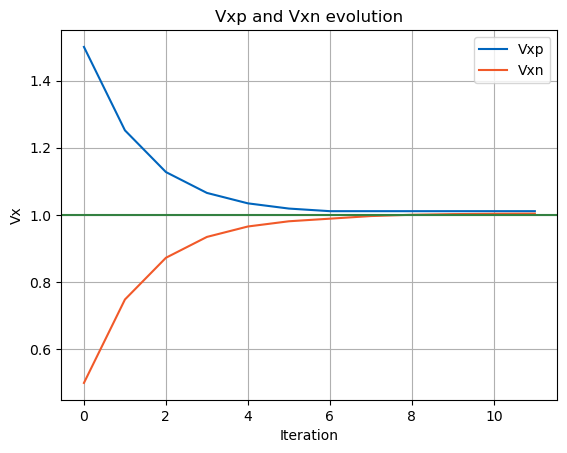

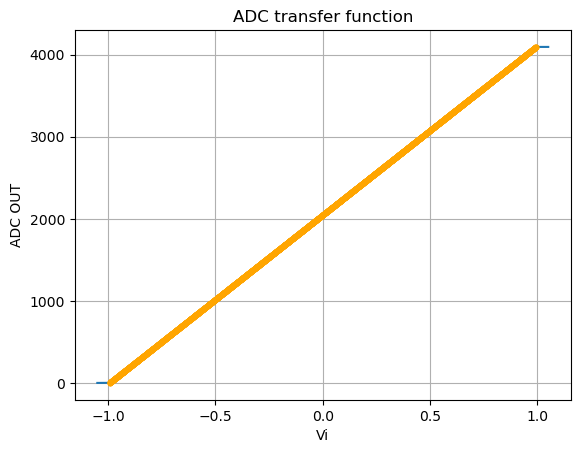

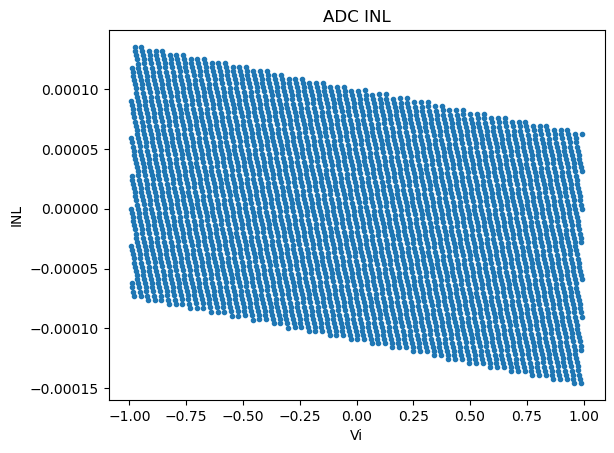

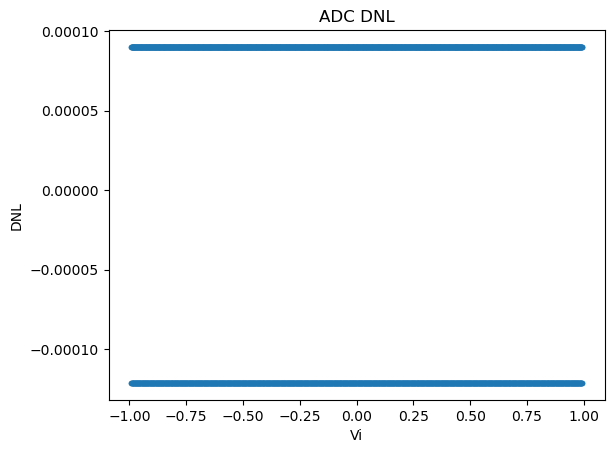

In [6]:
print( "VLSB Real             = " +str( vlsbreal ))
print( "Erro Vlsb             = ", (vlsbreal - vlsbideal)/vlsbideal )
print( "Erro linearidade(inl) = ", lin_inl)
print( "Erro linearidade(dnl) = ", lin_dnl)

%matplotlib inline

plt.plot([i for i in range(n_bits+1)],vip_arr,label="Vxp",color=Blue)
plt.plot([i for i in range(n_bits+1)],vin_arr,label="Vxn",color=Orange)
plt.axhline(y=1,color=Green)
plt.ylabel("Vx")
plt.xlabel("Iteration")
plt.title("Vxp and Vxn evolution")
plt.legend()
plt.grid(True)
plt.show()


plt.step(vin,tf_all,where='mid')
plt.step(vin_trans, code_trans, '.', color='orange')
plt.ylabel("ADC OUT")
plt.xlabel("Vi")
plt.title("ADC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()

plt.step(vin_trans,inl,'.',label="INL")
plt.ylabel("INL")
plt.xlabel("Vi")
plt.title("ADC INL")
plt.show()

plt.step(vin_trans[:-1],dnl,'.',label="DNL")
plt.ylabel("DNL")
plt.xlabel("Vi")
plt.title("ADC DNL")
plt.show()


#### FFT Test

Signal Power =  1.0
Noise Power =  3.5241641824099694e-06
SNR =  54.52943867043838
ENOB =  8.765687486783785


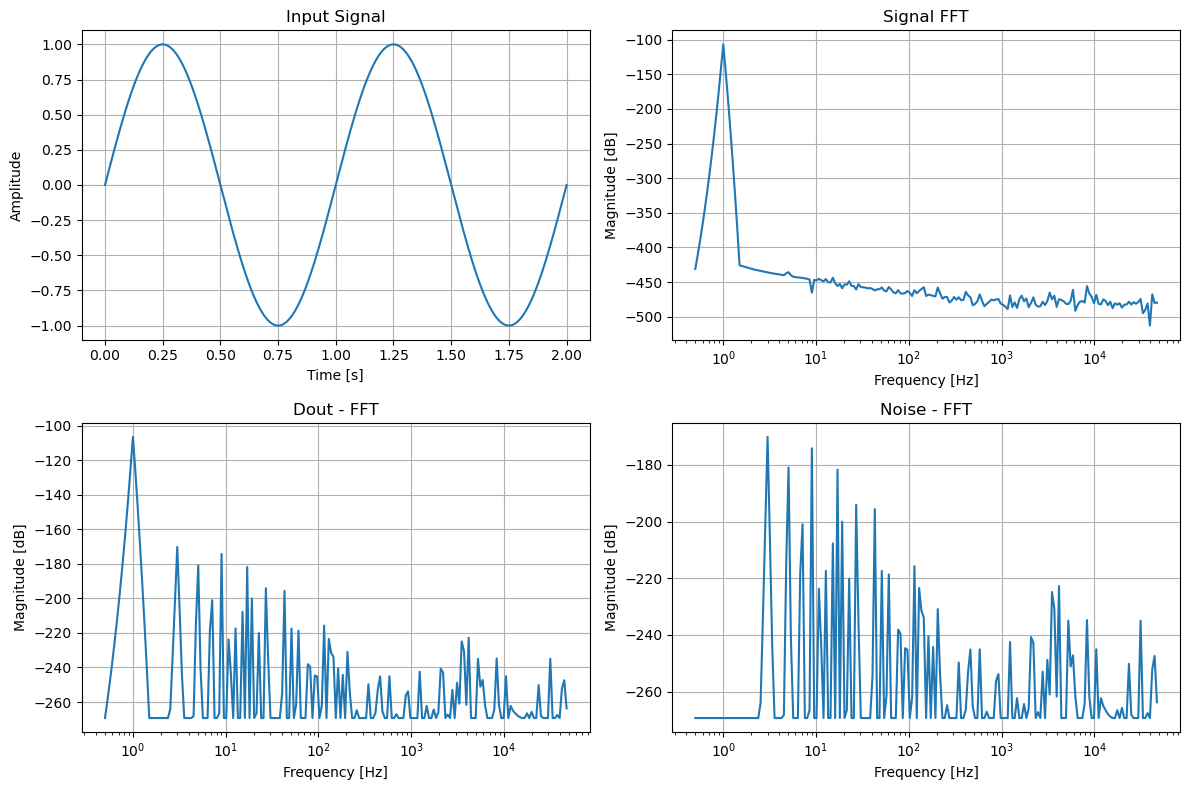

In [7]:
fs = 10e4
T  = 2.0
f0 = 1.0   

t = np.linspace(0, T, int(fs*T), endpoint=False)

vin = np.sin(2 * np.pi * f0 * t)

Dout = np.asarray([ adc(v,weights,weights,n_bits,Voffset=0)*vlsbreal - vr for v in vin ])

# Compute FFT
N = len(vin)
freq = np.fft.fftfreq(N, 1/fs)
mask = freq > 0
freq = freq[mask]

VIN   = np.fft.fft(vin)[mask]
DOUT  = np.fft.fft(Dout)[mask]
VIN  /= np.max(np.abs(VIN))
DOUT /= np.max(np.abs(DOUT))
Noise = np.abs(DOUT-VIN) 

VIN  = np.abs(VIN)
DOUT = np.abs(DOUT)

Psignal = np.sum(VIN**2)
Pnoise  = np.sum(Noise**2)
SNR     = 10*np.log10(Psignal/Pnoise)
ENOB    = (SNR - 1.76)/6.02

print("Signal Power = ",Psignal)
print("Noise Power = ",Pnoise)
print("SNR = ",SNR)
print("ENOB = ",ENOB)

VIN_mag   = 20*np.log10(VIN / N)
DOUT_mag  = 20*np.log10(10e-15+(DOUT / N))
Noise_mag = 20*np.log10(10e-15+ (Noise / N))

f_min = freq[0]
f_max = fs / 2
num_bins = 200
log_freqs = np.logspace(np.log10(f_min), np.log10(f_max), num_bins)

VIN_interp  = interp1d(freq, VIN_mag, kind='linear', bounds_error=False, fill_value=0.0)
DOUT_interp = interp1d(freq, DOUT_mag, kind='linear', bounds_error=False, fill_value=0.0)
Noise_int   = interp1d(freq, Noise_mag, kind='linear', bounds_error=False, fill_value=0.0)
VIN_log     = VIN_interp(log_freqs)
DOUT_log    = DOUT_interp(log_freqs)
Noise_log   = Noise_int(log_freqs)
# Plot in 2x2 subfigures
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Time-domain plots
axs[0, 0].plot(t, vin)
axs[0, 0].set_title('Input Signal')
axs[0, 0].set_xlabel('Time [s]')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].grid(True)

axs[0, 1].semilogx(log_freqs[:-1], VIN_log[:-1])
axs[0, 1].set_title('Signal FFT')
axs[0, 1].set_xlabel('Frequency [Hz]')
axs[0, 1].set_ylabel('Magnitude [dB]')
axs[0, 1].grid(True)

# Frequency-domain plots
axs[1, 0].semilogx(log_freqs[:-1], DOUT_log[:-1])
axs[1, 0].set_title('Dout - FFT')
axs[1, 0].set_xlabel('Frequency [Hz]')
axs[1, 0].set_ylabel('Magnitude [dB]')
axs[1, 0].grid(True)

axs[1, 1].semilogx(log_freqs[:-1],Noise_log[:-1] )
axs[1, 1].set_title('Noise - FFT')
axs[1, 1].set_xlabel('Frequency [Hz]')
axs[1, 1].set_ylabel('Magnitude [dB]')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


# Monte Carlo

## Generate Values

In [8]:
def _seed_worker():
    # Combine OS entropy with the PID for a unique seed per process
    pid   = os.getpid()
    seed  = int.from_bytes(os.urandom(4), 'little') ^ pid
    np.random.seed(seed)

def gen_components(s_cap):

    mc_C_ai  = np.asarray([ 1, 2, 4, 8, 16,32])
    mc_C_bi  = np.asarray([ 1, 2, 4, 8, 16,32])
    mc_C_Li  = np.asarray([ 1, 2, 4, 8 ])
    mc_C_M0  = 1 
    mc_C_B   = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )#2
    mc_C_B0l = np.random.normal(loc=C_B0l, scale=s_cap)#( (2**(len(C_Li))) - 1 )
    
    #mc_C_ai = np.random.normal(loc=C_ai,  scale=s_cap, size=(C_ai.size))
    #mc_C_bi = np.random.normal(loc=C_bi,  scale=s_cap, size=(C_bi.size))
    #mc_C_Li = np.random.normal(loc=C_Li,  scale=s_cap, size=(C_Li.size))

    #mc_C_M0  = np.random.normal(loc=C_M0 , scale=s_cap)
    #mc_C_B   = np.random.normal(loc=C_B  , scale=s_cap)
    #mc_C_B0l = np.random.normal(loc=C_B0l, scale=s_cap)
    
    return mc_C_B,mc_C_ai, mc_C_bi, mc_C_Li, mc_C_M0, mc_C_B0l

def monte_carlo_worker():

    mc_C_B_p,mc_C_ai_p, mc_C_bi_p, mc_C_Li_p, mc_C_M0_p, mc_C_B0l_p = gen_components(scap)
    mc_C_B_n,mc_C_ai_n, mc_C_bi_n, mc_C_Li_n, mc_C_M0_n, mc_C_B0l_n = gen_components(scap)
    
    weights_plus =  dac_bit_weight(
        vr,
        mc_C_ai_p, mc_C_bi_p,
        mc_C_M0_p,mc_C_Li_p,
        mc_C_B_p, mc_C_B0l_p,
        n_bits
        )
    weights_minus =  dac_bit_weight(
        vr,
        mc_C_ai_n, mc_C_bi_n,
        mc_C_M0_n,mc_C_Li_n,
        mc_C_B_n, mc_C_B0l_n,
        n_bits
        )
    
    tf_all, vin = adc_tf(
        num_points,n_bits_dac,Vr*2,
        weights_plus,weights_minus,
        Voffset
        )
    
    tf_aux      = get_trans(vin,tf_all,n_bits_adc)
    vlsbaux     = adc_lsb(tf_aux[0])  

    Dout = np.asarray([ adc(v,weights_plus,weights_minus,n_bits,Voffset=0)*vlsbaux - vr for v in vin_sig ])

    DOUT  = np.fft.fft(Dout)[mask]
    DOUT /= np.max(np.abs(DOUT))
    Noise = np.abs(DOUT-VIN) 

    DOUT = np.abs(DOUT)

    Pnoise  = np.sum(Noise**2)
    SNR     = 10*np.log10(1/Pnoise)


    dnl,_,_     = adc_dnl(tf_aux[0],vlsbaux)
    inl_aux,min_inl,max_inl  = adc_inl(tf_aux[0],vlsbaux)
    lin  = adc_lin(max_inl,min_inl,n_bits+1)    
    return tf_aux,vlsbaux,dnl,inl_aux,lin,SNR

def monte_carlo(n_sim):

    global Vr, n_bits, num_points, n_bits_dac, n_bits_adc, Voffset
    Vr          = vr
    Voffset     = 0
    n_bits_dac  = C_ai.size + C_Li.size + 1
    n_bits_adc  = n_bits_dac + 1

    num_points  = 50*2**(n_bits_adc)

    with Pool(processes=cpu_count(),initializer=_seed_worker) as pool:
        async_results = [pool.apply_async(monte_carlo_worker) for _ in range(n_sim)]  # :contentReference[oaicite:2]{index=2}
        results = [r.get() for r in async_results]

    tf_list, vlsb_list, dnl_list, inl_list, lin_list, snr_list = zip(*results)

    tf_arr    = np.array(tf_list,   dtype=object)
    tf_list   = 0
    vlsb_arr  = np.array(vlsb_list, dtype=TYPE)
    vlsb_list = 0
    dnl_arr   = np.array(dnl_list,  dtype=object)
    dnl_list  = 0
    inl_arr   = np.array(inl_list,  dtype=object)
    inl_list  = 0
    lin_arr   = np.array(lin_list,  dtype=TYPE)
    lin_list  = 0
    snr_arr   = np.array(snr_list,  dtype=TYPE)

    return tf_arr, vlsb_arr, inl_arr, dnl_arr, lin_arr, snr_arr


In [9]:
#Ideal values
n_bits  = 11
C_ai    = np.asarray([ 1, 2, 4, 8, 16,32])
C_bi    = np.asarray([ 1, 2, 4, 8, 16,32])
C_Li    = np.asarray([ 1, 2, 4, 8 ])
C_M0    = 1
C_B     = 2#(2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )#2
C_B0l   = ( (2**(len(C_Li))) - 1 )
#C_B     = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )
#C_B0l   = 1
vr      = 1
Voffset = 0 

#Capacitor standard deviation
scap = 0.0011

# FFT parameters
fs = 10e4 # Sample Frequency
T  = 2.0  # Number of periods
f0 = 1.0   

t = np.linspace(0, T, int(fs*T), endpoint=False)

vin_sig = np.sin(2 * np.pi * f0 * t)
# Compute FFT
N = len(vin_sig)
freq = np.fft.fftfreq(N, 1/fs)
mask = freq > 0
freq = freq[mask]

VIN   = np.fft.fft(vin_sig)[mask]
VIN  /= np.max(np.abs(VIN))
nsim = 20000
res,vlsb_arr,inl_arr,dnl_arr,lin_arr,snr_arr = monte_carlo(nsim)

### Prepare Plots

In [10]:

#Make distribuition array

meanLin    = lin_arr.mean()
diff_aux   = np.abs(lin_arr - meanLin)
typLin_ind = np.argmin(diff_aux)
#diff_aux   = 0
minLin_ind = np.argmin(lin_arr)
maxLin_ind = np.argmax(lin_arr)

minLin = lin_arr[minLin_ind]
maxLin = lin_arr[maxLin_ind]

res_typ = res[typLin_ind]
res_min = res[minLin_ind]
res_max = res[maxLin_ind]

#res = 0

inl_typ = inl_arr[typLin_ind]
inl_min = inl_arr[minLin_ind]
inl_max = inl_arr[maxLin_ind]
#inl = 0

dnl_typ = dnl_arr[typLin_ind]
dnl_min = dnl_arr[minLin_ind]
dnl_max = dnl_arr[maxLin_ind]
#dnl = 0

vlsb_arr.sort()

minVlsb     = min( vlsb_arr )
maxVlsb     = max( vlsb_arr )
meanVlsb    = np.mean(vlsb_arr)
diff_aux    = np.abs(vlsb_arr - meanVlsb)
typVlsb_ind = np.argmin(diff_aux)
diff_aux    = 0
Vlsb_typ    = snr_arr[typVlsb_ind]

vlsb_val_arr = np.linspace(minVlsb, maxVlsb, 100)
n_val_arr    = np.zeros(100, dtype=int)

i = 0
for j in range(len(vlsb_val_arr)):

    while vlsb_val_arr[j] > vlsb_arr[i]:
        i += 1
        n_val_arr[j] += 1


lin_arr.sort()

lin_val_arr = np.linspace(minLin, maxLin, 100)
n_lin_arr   = np.zeros(100, dtype=int)

i = 0
for j in range(len(lin_val_arr)):

    while lin_val_arr[j] > lin_arr[i]:
        i += 1
        n_lin_arr[j] += 1

snr_arr.sort()
snr_max = np.max(snr_arr)
snr_min = np.min(snr_arr)

meanSNR    = np.mean(snr_arr)
diff_aux   = np.abs(snr_arr - meanSNR)
typSNR_ind = np.argmin(diff_aux)
diff_aux       = 0
snr_typ    = snr_arr[typSNR_ind]

snr_val_arr = np.linspace(snr_min,snr_max,100)
n_snr_arr   = np.zeros(100,dtype=int)

i  = 0
for j in range(len(snr_val_arr)):
    while snr_val_arr[j] > snr_arr[i]:
        i += 1
        n_snr_arr[j] += 1

## Monte Carlo Plots

In [11]:
print("Minimum value for Lsb [mV]= ","%.4f"%(minVlsb*1000))
print("Typical value for Lsb [mV]= ","%.4f"%(meanVlsb*1000))
print("Maximum value for Lsb [mV]= ","%.4f"%(maxVlsb*1000))
print()
print("Minimum value for Linearity = ","%.4f"%minLin)
print("Typical value for Linearity = ","%.4f"%meanLin)
print("Maximum value for Linearity = ","%.4f"%maxLin)
print()
print("Minimum SNR = ","%.4f"%snr_min)
print("Maximum SNR = ","%.4f"%snr_max)
print("Typical SNR = ","%.4f"%snr_typ)
print()
print("Minimum ENOB = ","%.4f"%((snr_min - 1.76)/6.02))
print("Typical ENOB = ","%.4f"%((snr_typ - 1.76)/6.02))
print("Maximum ENOB = ","%.4f"%((snr_max - 1.76)/6.02))


print("& Min &","%.4f"%(minVlsb*1000)   ,"&  ","%.4f"%minLin ,"& ","%.4f"%snr_min," & ","%.4f"%((snr_min - 1.76)/6.02)," \\\\\\cline{2-6}")
print("& Typ &", "%.4f"%(meanVlsb*1000) ,"&  ","%.4f"%meanLin,"& ","%.4f"%snr_max," & ","%.4f"%((snr_typ - 1.76)/6.02),"\\\\\\cline{2-6}")
print("& Max &", "%.4f"%(maxVlsb*1000)  ,"&  ","%.4f"%maxLin ,"& ","%.4f"%snr_typ," & ","%.4f"%((snr_max - 1.76)/6.02),"\\\\")

%matplotlib qt

plt.figure()
plt.step(res_min[0],res_min[1],where='pre',label="Min Linearity",color=Green)
plt.step(res_typ[0],res_typ[1],where='pre',label="Typ Linearity",color=Blue)
plt.step(res_max[0],res_max[1],where='pre',label="Max Linearity",color=Orange)
plt.ylabel("ADC OUT")
plt.xlabel("Vi [V]")
plt.title("ADC transfer function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

# Plot Vlsb distribution
plt.figure()
plt.step(vlsb_val_arr*1000, n_val_arr)
plt.ylabel("Number of occurrences")
plt.xlabel("Vlsb [mV]")
plt.title("ADC Real Vlsb")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure()
plt.step(lin_val_arr, n_lin_arr)
plt.ylabel("Number of occurrences")
plt.xlabel("Linearity [bits]")
plt.title("ADC Linearity")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure()
# Plot SNR distribution
plt.step(snr_val_arr, n_snr_arr)
plt.ylabel("Number of occurrences")
plt.xlabel("SNR [dB]")
plt.title("ADC SNR")
plt.grid(True)
plt.tight_layout()
plt.show()

#fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.figure()
# INL plot
plt.plot(res_typ[0], inl_typ, color=Blue, label="Typ Linearity")
plt.plot(res_min[0], inl_min, color=Green, label="Min Linearity")
plt.plot(res_max[0], inl_max, color=Orange, label="Max Linearity")
plt.ylabel("Vlsb's")
plt.xlabel("Vi [V]")
plt.title("ADC INL")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure()
# DNL plot
plt.plot(res_typ[0][:-1], dnl_typ, color=Blue, label="Typ Linearity")
plt.plot(res_min[0][:-1], dnl_min, color=Green, label="Min Linearity")
plt.plot(res_max[0][:-1], dnl_max, color=Orange, label="Max Linearity")
plt.ylabel("Vlsb's")
plt.xlabel("Vi [V]")
plt.title("ADC DNL")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Minimum value for Lsb [mV]=  0.4866
Typical value for Lsb [mV]=  0.4866
Maximum value for Lsb [mV]=  0.4866

Minimum value for Linearity =  7.2498
Typical value for Linearity =  7.2498
Maximum value for Linearity =  7.2498

Minimum SNR =  51.3364
Maximum SNR =  51.3385
Typical SNR =  51.3371

Minimum ENOB =  8.2353
Typical ENOB =  8.2354
Maximum ENOB =  8.2356
& Min & 0.4866 &   7.2498 &  51.3364  &  8.2353  \\\cline{2-6}
& Typ & 0.4866 &   7.2498 &  51.3385  &  8.2354 \\\cline{2-6}
& Max & 0.4866 &   7.2498 &  51.3371  &  8.2356 \\


## Particular Variation

### $V_{\text{offset}}$

In [13]:
#return 0
#Ideal values
n_bits  = 11
C_ai    = np.asarray([ 1, 2, 4, 8, 16,32])
C_bi    = np.asarray([ 1, 2, 4, 8, 16,32])
C_Li    = np.asarray([ 1, 2, 4, 8 ])
C_M0    = 1
C_B     = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )
C_B0l   = 1
vr      = 1
Voffset = 0 

weights = dac_bit_weight(
            vr,
            C_ai,
            C_bi,
            C_M0, 
            C_Li,
            C_B,
            C_B0l,
            n_bits=n_bits
) 


fs = 10e4
T  = 2.0
f0 = 1.0   

t = np.linspace(0, T, int(fs*T), endpoint=False)

vin_sig = np.sin(2 * np.pi * f0 * t)
# Compute FFT
N = len(vin_sig)
freq = np.fft.fftfreq(N, 1/fs)
mask = freq > 0
freq = freq[mask]

VIN   = np.fft.fft(vin_sig)[mask]
VIN  /= np.max(np.abs(VIN))

v_start = -0.01
v_end   = 0.01
npoints = 500

Voffset_arr = np.linspace(v_start,v_end,npoints)
res_arr     = np.empty( shape=(npoints,2),dtype=object )
dnl_arr     = np.empty(npoints,dtype=object) 
inl_arr     = np.empty(npoints,dtype=object)
lin_arr     = np.empty(npoints,dtype=TYPE)
snr_arr     = np.empty(npoints,dtype=TYPE)
vlsb_arr    = np.empty(npoints,dtype=TYPE)

def Voffset_loop():
    for i in prange(npoints):

        tf_aux, vin_aux = adc_tf(50*(2<<n_bits),n_bits,vr*2,weights,weights,Voffset = Voffset_arr[i])
        res_aux         = get_trans(vin_aux,tf_aux,n_bits+1)
        vlsbaux         = adc_lsb(res_aux[0])  

        Dout = np.asarray([ adc(v,weights,weights,n_bits,Voffset=Voffset_arr[i])*vlsbaux - vr for v in vin_sig ])

        DOUT  = np.fft.fft(Dout)[mask]
        DOUT /= np.max(np.abs(DOUT))
        Noise = np.abs(DOUT-VIN) 

        DOUT = np.abs(DOUT)

        Pnoise  = np.sum(Noise**2)
        SNR     = 10*np.log10(1/Pnoise)

        dnl,_,_     = adc_dnl(res_aux[0],vlsbaux)
        inl_aux,min_inl,max_inl  = adc_inl(res_aux[0],vlsbaux)
        lin  = adc_lin(max_inl,min_inl,n_bits+1)    

        snr_arr[i]  = SNR
        res_arr[i]  = res_aux
        dnl_arr[i]  = dnl
        inl_arr[i]  = inl_aux
        lin_arr[i]  = lin        
        vlsb_arr[i] = vlsbaux

    return res_arr,dnl_arr,inl_arr,lin_arr,snr_arr,vlsb_arr

res_arr,dnl_arr,inl_arr,lin_arr,snr_arr,vlsb_arr = Voffset_loop()



In [14]:
#Make distribuition array

meanLin    = lin_arr.mean()
diff_aux   = np.abs(lin_arr - meanLin)
typLin_ind = np.argmin(diff_aux)
#diff_aux   = 0
minLin_ind = np.argmin(lin_arr)
maxLin_ind = np.argmax(lin_arr)

minLin = lin_arr[minLin_ind]
maxLin = lin_arr[maxLin_ind]

res_typ = res_arr[int(npoints/2)]
res_min = res_arr[0]
res_max = res_arr[npoints - 1]

#res_arr = 0

inl_typ = inl_arr[typLin_ind]
inl_min = inl_arr[minLin_ind]
inl_max = inl_arr[maxLin_ind]
#inl = 0

dnl_typ = dnl_arr[typLin_ind]
dnl_min = dnl_arr[minLin_ind]
dnl_max = dnl_arr[maxLin_ind]
#dnl = 0

vlsb_arr.sort()

minVlsb = min( vlsb_arr )
maxVlsb = max( vlsb_arr )
meanVlsb    = np.mean(vlsb_arr)
diff_aux    = np.abs(vlsb_arr - meanVlsb)
typVlsb_ind = np.argmin(diff_aux)
diff_aux    = 0
Vlsb_typ    = snr_arr[typVlsb_ind]

vlsb_val_arr = np.linspace(minVlsb, maxVlsb, 100)
n_val_arr    = np.zeros(100, dtype=int)

i = 0
for j in range(len(vlsb_val_arr)):

    while vlsb_val_arr[j] > vlsb_arr[i]:
        i += 1
        n_val_arr[j] += 1


lin_arr.sort()

lin_val_arr = np.linspace(minLin, maxLin, 100)
n_lin_arr   = np.zeros(100, dtype=int)

i = 0
for j in range(len(lin_val_arr)):

    while lin_val_arr[j] > lin_arr[i]:
        i += 1
        n_lin_arr[j] += 1

snr_arr.sort()
snr_max = np.max(snr_arr)
snr_min = np.min(snr_arr)

meanSNR    = np.mean(snr_arr)
diff_aux   = np.abs(snr_arr - meanSNR)
typSNR_ind = np.argmin(diff_aux)
diff_aux       = 0
snr_typ    = snr_arr[typSNR_ind]

snr_val_arr = np.linspace(snr_min,snr_max,100)
n_snr_arr   = np.zeros(100,dtype=int)

i  = 0
for j in range(len(snr_val_arr)):
    while snr_val_arr[j] > snr_arr[i]:
        i += 1
        n_snr_arr[j] += 1

In [15]:
print("Minimum value for Lsb [mV] = ","%.4f"%(minVlsb*1000))
print("Typical value for Lsb [mV] = ","%.4f"%(meanVlsb*1000))
print("Maximum value for Lsb [mV] = ","%.4f"%(maxVlsb*1000))
print()
print("Minimum value for Linearity = ","%.4f"%minLin)
print("Maximum value for Linearity = ","%.4f"%maxLin)
print("Typical value for Linearity = ","%.4f"%meanLin)
print()
print("Minimum SNR = ","%.4f"%snr_min)
print("Maximum SNR = ","%.4f"%snr_max)
print("Typical SNR = ","%.4f"%snr_typ)
print()
print("Minimum ENOB = ","%.4f"%((snr_min - 1.76)/6.02))
print("Maximum ENOB = ","%.4f"%((snr_max - 1.76)/6.02))
print("Typical ENOB = ","%.4f"%((snr_typ - 1.76)/6.02))

print("& Min &","%.4f"%(minVlsb*1000)   ,"&  ","%.4f"%minLin ,"& ","%.4f"%snr_min," & ","%.4f"%((snr_min - 1.76)/6.02)," \\\\\\cline{2-6}")
print("& Typ &", "%.4f"%(meanVlsb*1000) ,"&  ","%.4f"%meanLin,"& ","%.4f"%snr_max," & ","%.4f"%((snr_typ - 1.76)/6.02),"\\\\\\cline{2-6}")
print("& Max &", "%.4f"%(maxVlsb*1000)  ,"&  ","%.4f"%maxLin ,"& ","%.4f"%snr_typ," & ","%.4f"%((snr_max - 1.76)/6.02),"\\\\")


%matplotlib qt
#%matplotlib inline
plt.figure()
plt.step(res_min[0],res_min[1],where='pre',label="Min Linearity",color=Green)
plt.step(res_typ[0],res_typ[1],where='pre',label="Typ Linearity",color=Blue)
plt.step(res_max[0],res_max[1],where='pre',label="Max Linearity",color=Orange)
plt.ylabel("ADC OUT")
plt.xlabel("Vi [V]")
plt.title("ADC transfer function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

# Plot Vlsb distribution
axs[0].step(vlsb_val_arr*1000, n_val_arr)
axs[0].set_ylabel("Number of occurrences")
axs[0].set_xlabel("Vlsb [mV]")
axs[0].set_title("ADC Real Vlsb")
axs[0].grid(True)

# Plot Linearity distribution
axs[1].step(lin_val_arr, n_lin_arr)
axs[1].set_ylabel("Number of occurrences")
axs[1].set_xlabel("Linearity [bits]")
axs[1].set_title("ADC Linearity")
axs[1].grid(True)

plt.tight_layout()
plt.show()

plt.figure()
# Plot SNR distribution
plt.step(snr_val_arr, n_snr_arr)
plt.ylabel("Number of occurrences")
plt.xlabel("SNR [dB]")
plt.title("ADC SNR")
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# INL plot
axs[0].plot(res_typ[0], inl_typ, color=Blue, label="Typ Linearity")
axs[0].plot(res_min[0], inl_min, color=Green, label="Min Linearity")
axs[0].plot(res_max[0], inl_max, color=Orange, label="Max Linearity")
axs[0].set_ylabel("Vlsb's")
axs[0].set_xlabel("Vi [V]")
axs[0].set_title("ADC INL")
axs[0].legend()
axs[0].grid(True)

# DNL plot
axs[1].plot(res_typ[0][:-1], dnl_typ, color=Blue, label="Typ Linearity")
axs[1].plot(res_min[0][:-1], dnl_min, color=Green, label="Min Linearity")
axs[1].plot(res_max[0][:-1], dnl_max, color=Orange, label="Max Linearity")
axs[1].set_ylabel("Vlsb's")
axs[1].set_xlabel("Vi [V]")
axs[1].set_title("ADC DNL")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Minimum value for Lsb [mV] =  0.4883
Typical value for Lsb [mV] =  0.4895
Maximum value for Lsb [mV] =  0.4907

Minimum value for Linearity =  7.6506
Maximum value for Linearity =  16.3668
Typical value for Linearity =  9.0797

Minimum SNR =  53.2113
Maximum SNR =  73.9729
Typical SNR =  61.5979

Minimum ENOB =  8.5467
Maximum ENOB =  11.9955
Typical ENOB =  9.9399
& Min & 0.4883 &   7.6506 &  53.2113  &  8.5467  \\\cline{2-6}
& Typ & 0.4895 &   9.0797 &  73.9729  &  9.9399 \\\cline{2-6}
& Max & 0.4907 &   16.3668 &  61.5979  &  11.9955 \\


ValueError: x and y must have same first dimension, but have shapes (4095,) and (4088,)